# SCAT Trajectory Analysis with Weather Features

**Objective:**  
Analyze and model flight trajectories using the SCAT dataset with weather data.

**Pipeline Overview:**
- Load and summarize train/val/test splits
- Visualize flights (2D/3D + weather)
- Engineer features (velocity, bearing)
- Normalize + build PyTorch dataset
- Train GRU sequence model
- Evaluate predictions (MAE, RMSE, plots)

## imports & config

In [2]:
# basic stuff
import os, sys, math, random, time
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# paths 
project_root = "C:/Users/flyin/OneDrive/Documents/GitHub/dataset-research-SCAT"
data_dir = f"{project_root}/data/validated_data"
parquet_path = f"{data_dir}/validated_cleaned_FINAL.parquet" 
split_dir = data_dir

assert os.path.exists(parquet_path), f"Missing dataset at {parquet_path}"

In [4]:
# reproducibility-ish
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Load Splits

In [5]:
# load parquet
df_all = pd.read_parquet(parquet_path)

# types + basics
df_all["time"] = pd.to_datetime(df_all["time"])
df_all["flight_id"] = df_all["flight_id"].astype(str)

print("raw shape:", df_all.shape, "| flights:", df_all["flight_id"].nunique())
print(df_all.head(3))

raw shape: (70197504, 8) | flights: 167536
  flight_id                       time        lat        lon     alt  temp  \
0    100000 2016-10-20 11:40:02.898437  55.348172  13.029962  146.25 -48.0   
1    100000 2016-10-20 11:40:07.898437  55.340731  13.036260  149.00 -48.0   
2    100000 2016-10-20 11:40:12.898437  55.333242  13.042418  150.25 -48.0   

   wind_spd  wind_dir  
0        15     113.2  
1        15     113.2  
2        15     113.2  


In [8]:
# split helpers
def split_by_flight(df, train_frac=0.8, val_frac=0.1):
    fids = df["flight_id"].unique()
    rng = np.random.default_rng(seed); rng.shuffle(fids)
    n = len(fids)
    n_train = int(n*train_frac); n_val = int(n*val_frac)
    train_f = set(fids[:n_train])
    val_f   = set(fids[n_train:n_train+n_val])
    test_f  = set(fids[n_train+n_val:])
    return (
        df[df.flight_id.isin(train_f)].copy(),
        df[df.flight_id.isin(val_f)].copy(),
        df[df.flight_id.isin(test_f)].copy()
    )

# keep flights with at least "min_points" rows, then cap the number of flights per split
def limit_flights(df, min_points=200, max_flights=None):
    counts = df.groupby("flight_id").size()
    keep = counts[counts >= min_points].index
    df = df[df.flight_id.isin(keep)]
    if max_flights is not None and len(keep) > max_flights:
        keep_small = np.random.default_rng(seed).choice(keep, size=max_flights, replace=False)
        df = df[df.flight_id.isin(keep_small)]
    return df

# train_df, val_df, test_df = split_by_flight(df_all)

# # dial these numbers up/down once it works
# train_df = limit_flights(train_df, min_points=200, max_flights=1500)
# val_df   = limit_flights(val_df,   min_points=200, max_flights=300)
# test_df  = limit_flights(test_df,  min_points=200, max_flights=300)

# for name, df in [("train",train_df),("val",val_df),("test",test_df)]:
#     print(name, df.shape, "flights:", df["flight_id"].nunique(),
#           "time:", df["time"].min(), "→", df["time"].max())

## Data Exploration

In [6]:
def explore_data(df, name=""):
    print(f"\n{'='*40}\n{name} Dataset Info\n{'='*40}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Flight IDs: {df['flight_id'].nunique()} unique")
    if "time" in df:
        times = pd.to_datetime(df["time"])
        print(f"\nTime Range: {times.min()} to {times.max()}")
    missing = df.isnull().sum()
    print("\nMissing Values:")
    print(missing[missing > 0].to_string() if missing.any() else "None")
    print("\nNumeric Stats:")
    num = df.select_dtypes(include='number')
    if len(num.columns):
        print(num.describe().loc[['mean','std','min','max']].T)
    else:
        print("None")

explore_data(train_df, "TRAIN")
explore_data(val_df,   "VALIDATION")
explore_data(test_df,  "TEST")


TRAIN Dataset Info
Shape: (712933, 8)
Columns: ['flight_id', 'time', 'lat', 'lon', 'alt', 'temp', 'wind_spd', 'wind_dir']
Flight IDs: 1500 unique

Time Range: 2016-10-15 01:17:52.296875 to 2017-09-22 18:53:10.898437

Missing Values:
None

Numeric Stats:
                mean         std        min         max
lat        58.446386    2.391680  54.265525   68.878559
lon        16.042142    2.346408  10.530562   23.952733
alt       265.581358  120.952162   0.250000  430.000000
temp      -32.326613   23.263552 -73.000000   10.000000
wind_spd   34.159158   24.089502   0.000000  144.000000
wind_dir  229.003853   97.175388   0.000000  357.900000

VALIDATION Dataset Info
Shape: (138903, 8)
Columns: ['flight_id', 'time', 'lat', 'lon', 'alt', 'temp', 'wind_spd', 'wind_dir']
Flight IDs: 300 unique

Time Range: 2016-10-15 01:12:52.500000 to 2017-09-22 11:12:23.500000

Missing Values:
None

Numeric Stats:
                mean         std        min         max
lat        58.353918    2.135599  54.2

## Data Visualization

Randomly selected flight_id: 1108887


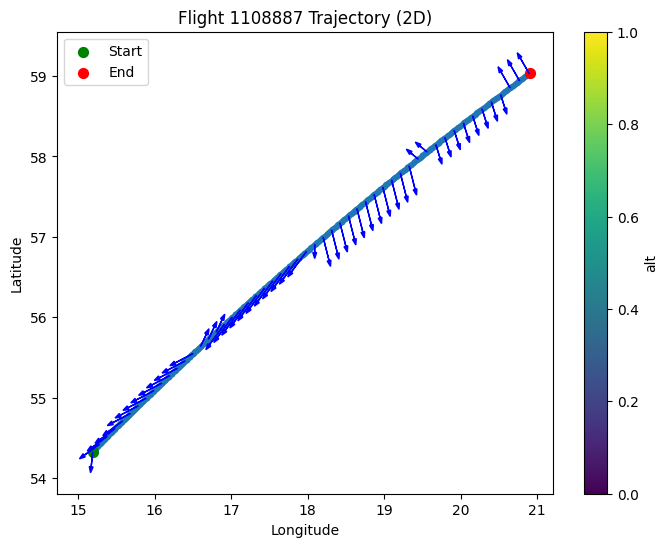

In [89]:
# Visualize a random flight (2D)
plot_flight(parquet_path, mode="2D", color_by="alt", show_wind=True)

Randomly selected flight_id: 300505


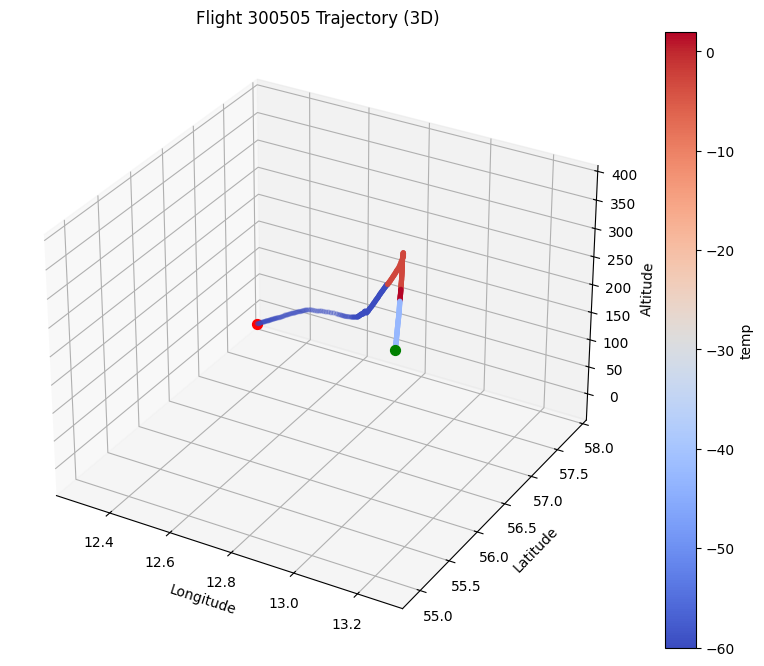

In [90]:
# Visualize the same flight in 3D
plot_flight(parquet_path, mode="3D", color_by="temp")

# Feature Engineering

In [9]:
# motion features (m/s)
def add_features(df):
    df = df.sort_values(["flight_id","time"]).copy()
    dt = df.groupby("flight_id")["time"].diff().dt.total_seconds()
    df = df[(dt >= 1.0) & np.isfinite(dt)].copy()
    df["dt"] = dt

    # diffs to meters using local equirectangular approx
    R = 6_371_000.0
    lat_rad = np.radians(df["lat"])
    dlat = np.radians(df.groupby("flight_id")["lat"].diff())
    dlon = np.radians(df.groupby("flight_id")["lon"].diff())
    y_m = dlat * R
    x_m = dlon * R * np.cos(lat_rad)

    vx = (x_m / df["dt"]).clip(-400, 400)     # ~±1440 km/h
    vy = (y_m / df["dt"]).clip(-400, 400)
    climb = (df.groupby("flight_id")["alt"].diff() / df["dt"]).clip(-30, 30)

    df["vx_ms"] = vx.astype("float32")
    df["vy_ms"] = vy.astype("float32")
    df["climb_ms"] = climb.astype("float32")

    # keep necessary cols
    df = df.dropna(subset=["lat","lon","alt","vx_ms","vy_ms","climb_ms","dt"])
    return df

In [10]:
# build splits
train_df, val_df, test_df = split_by_flight(df_all)
train_df = limit_flights(train_df, min_points=200, max_flights=1500)
val_df   = limit_flights(val_df,   min_points=200, max_flights=300)
test_df  = limit_flights(test_df,  min_points=200, max_flights=300)

train_df = add_features(train_df)
val_df   = add_features(val_df)
test_df  = add_features(test_df)

for name, df in [("train",train_df),("val",val_df),("test",test_df)]:
    print(name, df.shape, "flights:", df["flight_id"].nunique(),
          "time:", df["time"].min(), "→", df["time"].max())

train (709933, 12) flights: 1500 time: 2016-10-15 01:18:02.296875 → 2017-09-22 18:53:10.898437
val (138303, 12) flights: 300 time: 2016-10-15 01:13:02.500000 → 2017-09-22 11:12:23.500000
test (143240, 12) flights: 300 time: 2016-10-15 05:45:58 → 2017-09-22 18:36:01.296875


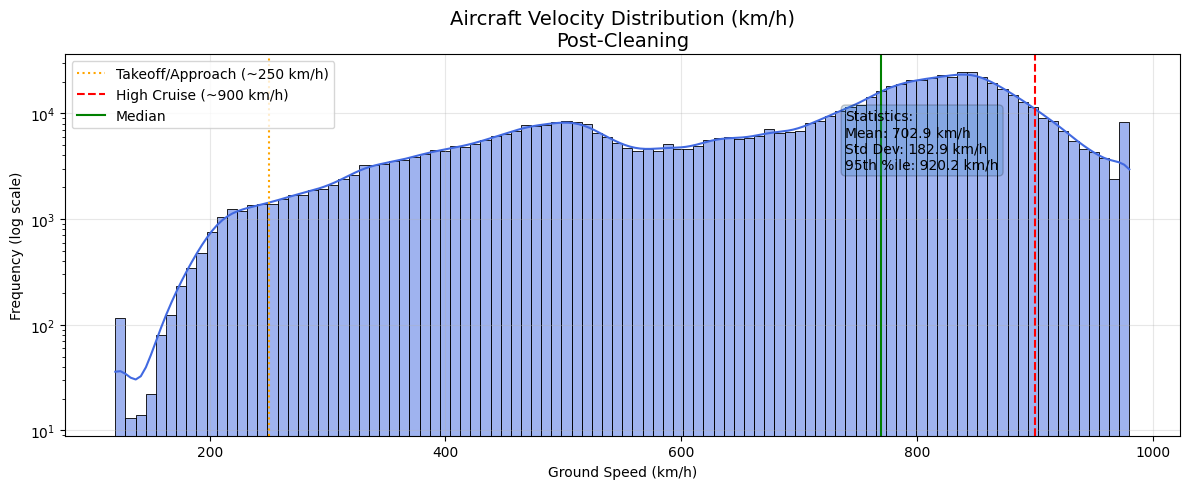

In [10]:
plt.figure(figsize=(12,5))
ax = sns.histplot(train_df['velocity_kmh'], bins=100, kde=True, color='royalblue')

# add key aviation speed markers
plt.axvline(250, color='orange', linestyle=':', label='Takeoff/Approach (~250 km/h)')
plt.axvline(900, color='red', linestyle='--', label='High Cruise (~900 km/h)')
plt.axvline(train_df['velocity_kmh'].median(), color='green', linestyle='-', label='Median')

plt.title('Aircraft Velocity Distribution (km/h)\nPost-Cleaning', fontsize=14)
plt.xlabel('Ground Speed (km/h)')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')  
plt.legend()
plt.grid(alpha=0.3)

# Annotate stats box
stats_text = (
    f"Statistics:\n"
    f"Mean: {train_df['velocity_kmh'].mean():.1f} km/h\n"
    f"Std Dev: {train_df['velocity_kmh'].std():.1f} km/h\n"
    f"95th %ile: {train_df['velocity_kmh'].quantile(0.95):.1f} km/h"
)
plt.annotate(stats_text, xy=(0.70, 0.70), xycoords='axes fraction',
             bbox=dict(boxstyle='round', alpha=0.2))

plt.tight_layout()
plt.show()

# dataset
Inputs = [lat, lon, alt, velocity_kmh, climb_rate_ms]

Targets = [lat, lon, alt]

In [11]:
SEQ_LEN  = 20
PRED_LEN = 5
STRIDE   = 3
BATCH    = 128

In [21]:
class TrajectoryDataset(Dataset):
    """
    Returns (past_n, fut_n, y0, scale_xyz, origin_lla):
      past_n : (seq, 6)  -> [x_m,y_m,z_m,vx_ms,vy_ms,climb_ms] / local scales
      fut_n  : (pred, 3) -> [dx_m,dy_m,dz_m] / local scales
      y0     : (3,)      -> last past position (should be ~0,0,0) in normalized units
      scale_xyz: (3,)    -> [s_xy, s_xy, s_z] used to denorm meters
      origin_lla: (3,)   -> [lat0_deg, lon0_deg, alt0_m] of the window origin
    """
    def __init__(self, df, seq_len, pred_len, stride=3, cap_per_flight=None):
        self.seq_len, self.pred_len, self.stride = int(seq_len), int(pred_len), int(stride)
        self.cap_per_flight = cap_per_flight
        self.R = 6_371_000.0

        self.groups = {}
        self.index  = []
        for fid, g in df.groupby("flight_id"):
            g = g.sort_values("time").reset_index(drop=True)
            n = len(g); max_start = n - (self.seq_len + self.pred_len)
            if max_start < 0: continue
            total = (max_start // self.stride) + 1
            if cap_per_flight and total > cap_per_flight: total = cap_per_flight
            self.groups[fid] = g
            for k in range(total):
                self.index.append((fid, int(k*self.stride)))

    def __len__(self): return len(self.index)

    def __getitem__(self, i):
        fid, s = self.index[i]
        g = self.groups[fid].iloc[s : s + self.seq_len + self.pred_len].copy()

        lat0_deg = float(g.iloc[self.seq_len-1]["lat"])
        lon0_deg = float(g.iloc[self.seq_len-1]["lon"])
        alt0_m   = float(g.iloc[self.seq_len-1]["alt"])
        lat0 = math.radians(lat0_deg); lon0 = math.radians(lon0_deg)

        R = self.R
        lat_r = np.radians(g["lat"].to_numpy())
        lon_r = np.radians(g["lon"].to_numpy())
        x = (lon_r - lon0) * R * math.cos(lat0)
        y = (lat_r - lat0) * R
        z = g["alt"].to_numpy() - alt0_m

        # controls (m/s)
        vx = g["vx_ms"].to_numpy()
        vy = g["vy_ms"].to_numpy()
        cl = g["climb_ms"].to_numpy()

        past = np.stack([
            x[:self.seq_len], y[:self.seq_len], z[:self.seq_len],
            vx[:self.seq_len], vy[:self.seq_len], cl[:self.seq_len]
        ], axis=1).astype("float32")

        fut_pos = np.stack([x[self.seq_len:], y[self.seq_len:], z[self.seq_len:]], axis=1).astype("float32")
        fut_ctl = np.stack([vx[self.seq_len:], vy[self.seq_len:], cl[self.seq_len:]], axis=1).astype("float32")

        # local scales
        s_xy = float(max(50.0, 2.0*np.max(np.abs(past[:,0:2]))))
        s_z  = float(max(20.0, 2.0*np.max(np.abs(past[:,2]))))
        scale6 = np.array([s_xy,s_xy,s_z, 200.0,200.0,10.0], dtype="float32")
        scale3 = np.array([s_xy,s_xy,s_z], dtype="float32")
        ctl_scale = np.array([200.0,200.0,10.0], dtype="float32")

        past_n    = past / scale6
        fut_pos_n = fut_pos / scale3
        fut_ctl_n = fut_ctl / ctl_scale

        y0 = past_n[-1, :3]
        origin_lla = np.array([lat0_deg, lon0_deg, alt0_m], dtype="float32")

        return (torch.from_numpy(past_n),
                torch.from_numpy(fut_pos_n),
                torch.from_numpy(fut_ctl_n),
                torch.from_numpy(y0),
                torch.from_numpy(scale3),
                torch.from_numpy(origin_lla))

In [22]:
# dataloaders 
pin_mem = (device.type == "cuda")
train_ds = TrajectoryDataset(train_df, SEQ_LEN, PRED_LEN, STRIDE, cap_per_flight=800)
val_ds   = TrajectoryDataset(val_df,   SEQ_LEN, PRED_LEN, STRIDE, cap_per_flight=400)
test_ds  = TrajectoryDataset(test_df,  SEQ_LEN, PRED_LEN, STRIDE, cap_per_flight=400)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=pin_mem)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=pin_mem)
test_loader  = DataLoader(test_ds,  batch_size=1,    shuffle=True,   num_workers=0)
print("windows:", len(train_ds), len(val_ds), len(test_ds))

windows: 225132 43804 45382


# model 

In [23]:
IN_SIZE  = 6      # [x,y,z,vx,vy,climb]
OUT_SIZE = 3      # position deltas
CTL_SIZE = 3      # [vx,vy,climb]

class TrajectoryPredictor(nn.Module):
    def __init__(self, in_size=IN_SIZE, out_size=OUT_SIZE, ctl_size=CTL_SIZE,
                 hidden=256, layers=2, drop=0.1):
        super().__init__()
        self.encoder  = nn.GRU(in_size, hidden, layers, batch_first=True,
                               dropout=drop if layers>1 else 0.0)
        self.dec_cell = nn.GRUCell(out_size + ctl_size, hidden)
        self.head     = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, out_size))

    def forward(self, x, y0, u, pred_len, teacher=None):
        """
        x: (B,seq,6), y0: (B,3) last past pos (norm), 
        u: (B,pred,3) future controls (norm),
        teacher: (B,pred,3) future true pos (norm) or None
        """
        _, h = self.encoder(x); h = h[-1]
        y_t = y0
        outs = []
        for t in range(pred_len):
            u_t = u[:, t]                          # controls for this step
            inp = torch.cat([y_t, u_t], dim=-1)    # [pos, controls]
            h = self.dec_cell(inp, h)
            y_hat = self.head(h)
            outs.append(y_hat.unsqueeze(1))
            y_t = teacher[:, t] if (teacher is not None) else y_hat
        return torch.cat(outs, dim=1)

model = TrajectoryPredictor().to(device)
print("Params:", sum(p.numel() for p in model.parameters()))

Params: 833539


# loss/metrics 

In [30]:
def meters_mse(pred_n, true_n, scale_xyz):
    # pred_n, true_n: (B,T,3) normalized; scale_xyz: (B,3)
    pred = pred_n * scale_xyz.unsqueeze(1)
    true = true_n * scale_xyz.unsqueeze(1)
    return ((pred - true) ** 2).mean()

def run_epoch(loader, train=True, tf_ratio=0.6):
    model.train(mode=train)
    total = 0.0; n = 0
    for batch in loader:
        # NEW: unpack 6 items (controls included)
        past, fut_pos, fut_ctl, y0, scale, origin = batch
        past   = past.to(device)
        fut_pos= fut_pos.to(device)
        fut_ctl= fut_ctl.to(device)
        y0     = y0.to(device)
        scale  = scale.to(device)

        teacher = fut_pos if (train and np.random.rand() < tf_ratio) else None

        # NEW: use torch.amp.autocast with device_type='cuda'
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            pred = model(past, y0, fut_ctl, pred_len=fut_pos.size(1), teacher=teacher)
            loss = meters_mse(pred, fut_pos, scale)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()

        total += loss.item() * past.size(0); n += past.size(0)
    return total / max(n, 1)

# train

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
scaler    = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

C:\Users\flyin\AppData\Local\Temp\ipykernel_27720\4237385178.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [31]:
def run_epoch(loader, train=True, tf_ratio=0.6):
    model.train(mode=train)
    total = 0.0; n = 0
    for batch in loader:
        past, fut_pos, fut_ctl, y0, scale, origin = batch
        past, fut_pos, fut_ctl, y0, scale = past.to(device), fut_pos.to(device), fut_ctl.to(device), y0.to(device), scale.to(device)
        teacher = fut_pos if (train and np.random.rand() < tf_ratio) else None
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            pred = model(past, y0, fut_ctl, pred_len=fut_pos.size(1), teacher=teacher)
            loss = meters_mse(pred, fut_pos, scale)   # same meters loss
        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
        total += loss.item()*past.size(0); n += past.size(0)
    return total/max(n,1)

In [32]:
EPOCHS = 20
BEST = float("inf")
os.makedirs("models", exist_ok=True)

In [33]:
for ep in range(1, EPOCHS + 1):
    tf = max(0.1, 0.8 * (1 - (ep - 1) / EPOCHS))
    tr = run_epoch(train_loader, True,  tf_ratio=tf)
    va = run_epoch(val_loader,   False, tf_ratio=0.0)

    # quick val meter (great-circle error in meters across horizon)
    with torch.no_grad():
        past, fut_pos, fut_ctl, y0, scale, origin = next(iter(val_loader))
        past   = past.to(device)
        fut_pos= fut_pos.to(device)
        fut_ctl= fut_ctl.to(device)
        y0     = y0.to(device)
        scale  = scale.to(device)

        pred = model(past, y0, fut_ctl, pred_len=fut_pos.size(1))

        # denorm to meters
        pred_m = pred    * scale.unsqueeze(1)   # (B,T,3)
        true_m = fut_pos * scale.unsqueeze(1)   # (B,T,3)

        # convert meters -> lat/lon (radians) around origin for haversine
        R = 6_371_000.0
        lat0 = torch.deg2rad(origin[:,0].to(device)).unsqueeze(1)  # (B,1)
        lon0 = torch.deg2rad(origin[:,1].to(device)).unsqueeze(1)  # (B,1)
        cos_lat0 = torch.cos(lat0)

        t_lat = lat0 + true_m[...,1] / R
        t_lon = lon0 + true_m[...,0] / (R * cos_lat0)
        p_lat = lat0 + pred_m[...,1] / R
        p_lon = lon0 + pred_m[...,0] / (R * cos_lat0)

        dlat = p_lat - t_lat
        dlon = p_lon - t_lon
        a = torch.sin(dlat/2)**2 + torch.cos(t_lat)*torch.cos(p_lat)*torch.sin(dlon/2)**2
        d = 2*R*torch.arcsin(torch.sqrt(torch.clamp(a, 0, 1)))
        meter = d.mean().item()

    scheduler.step(va)
    print(f"ep {ep:02d} | tf={tf:.2f} | train {tr:.5f} | val {va:.5f} | ~{meter:.0f} m")

    if va < BEST:
        BEST = va
        torch.save(model.state_dict(), "models/best.pt")
        print("  -> saved best")

C:\Users\flyin\AppData\Local\Temp\ipykernel_27720\2731118268.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


ep 01 | tf=0.80 | train 4787.61692 | val 2307.92894 | ~88 m
  -> saved best
ep 02 | tf=0.76 | train 2315.13598 | val 7423.31288 | ~139 m
ep 03 | tf=0.72 | train 2665.05833 | val 1870.90172 | ~54 m
  -> saved best
ep 04 | tf=0.68 | train 2025.68322 | val 3250.40523 | ~53 m
ep 05 | tf=0.64 | train 1792.24422 | val 2538.83084 | ~45 m
ep 06 | tf=0.60 | train 1987.47213 | val 1025.56003 | ~40 m
  -> saved best
ep 07 | tf=0.56 | train 1172.06474 | val 1884.54128 | ~82 m
ep 08 | tf=0.52 | train 1024.04113 | val 1378.30105 | ~49 m
ep 09 | tf=0.48 | train 1737.77306 | val 1585.13186 | ~44 m
ep 10 | tf=0.44 | train 772.50038 | val 707.77016 | ~21 m
  -> saved best
ep 11 | tf=0.40 | train 694.28159 | val 824.71344 | ~26 m
ep 12 | tf=0.36 | train 851.14320 | val 746.55926 | ~31 m
ep 13 | tf=0.32 | train 809.81080 | val 1482.92272 | ~67 m
ep 14 | tf=0.28 | train 613.23103 | val 584.89687 | ~18 m
  -> saved best
ep 15 | tf=0.24 | train 612.65819 | val 692.07659 | ~26 m
ep 16 | tf=0.20 | train 627.34

# eval + plot sample

Loaded best.


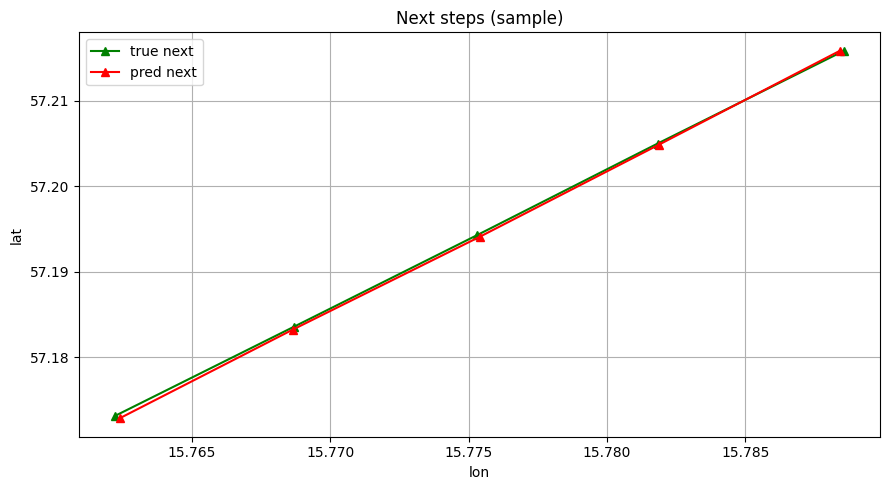

sample mean error ≈ 21.9 m


In [34]:
model.load_state_dict(torch.load("models/best.pt", map_location=device))
model.eval()
print("Loaded best.")

with torch.no_grad():
    # get one sample from test_loader 
    past, fut_pos, fut_ctl, y0, scale, origin = next(iter(test_loader))
    past   = past.to(device)         
    fut_pos= fut_pos.to(device)      
    fut_ctl= fut_ctl.to(device)     
    y0     = y0.to(device)           
    scale  = scale.to(device)        

    # predict
    pred = model(past, y0, fut_ctl, pred_len=fut_pos.size(1))

    # denorm to m 
    pred_m = (pred    * scale.unsqueeze(1))[0].cpu().numpy()  
    true_m = (fut_pos * scale.unsqueeze(1))[0].cpu().numpy()  

    # convert m → lat/lon
    R = 6_371_000.0
    lat0 = float(origin[0,0]); lon0 = float(origin[0,1])
    lat0r = np.radians(lat0); lon0r = np.radians(lon0)

    t_lat = lat0r + true_m[:,1] / R
    t_lon = lon0r + true_m[:,0] / (R * np.cos(lat0r))
    p_lat = lat0r + pred_m[:,1] / R
    p_lon = lon0r + pred_m[:,0] / (R * np.cos(lat0r))

    t_lat_deg = np.degrees(t_lat); t_lon_deg = np.degrees(t_lon)
    p_lat_deg = np.degrees(p_lat); p_lon_deg = np.degrees(p_lon)

    # plot
    plt.figure(figsize=(9,5))
    plt.plot(t_lon_deg, t_lat_deg, 'g^-', label="true next")
    plt.plot(p_lon_deg, p_lat_deg, 'r^-', label="pred next")
    plt.xlabel("lon"); plt.ylabel("lat"); plt.title("Next steps (sample)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # mean geodesic error in m
    dlat = p_lat - t_lat
    dlon = p_lon - t_lon
    a = np.sin(dlat/2)**2 + np.cos(t_lat)*np.cos(p_lat)*np.sin(dlon/2)**2
    d = 2*R*np.arcsin(np.sqrt(np.clip(a, 0, 1)))
    print(f"sample mean error ≈ {d.mean():.1f} m")